### Imports

In [24]:
import os
import sys
import random
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from skimage.io import imshow
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard
from tensorflow.keras.models import *
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import UpSampling2D, MaxPooling2D, Conv2D
from tensorflow.keras.layers import Input,  BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Building Model

#### Downsampling Block

In [2]:
def downsample_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    downsample_1 = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    downsample_2 = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(downsample_1)
    pooling = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(downsample_2)
    return downsample_2, pooling

#### Upsampling Block

In [3]:
def upsample_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    upsample = tf.keras.layers.UpSampling2D((2, 2))(x)
    concat = tf.keras.layers.Concatenate()([upsample, skip])
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

#### Bottleneck Layer

In [4]:
def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    downsample_1 = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    downsample_2 = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(downsample_1)
    return downsample_2

#### Final Model

In [5]:
def simple_unet(filters, inputs):
    p0 = inputs
    c1, p1 = downsample_block(p0, filters[0]) # 128 -> 64
    c2, p2 = downsample_block(p1, filters[1]) # 64 -> 32
    c3, p3 = downsample_block(p2, filters[2]) # 32 -> 16
    c4, p4 = downsample_block(p3, filters[3]) # 16 -> 8

    bn = bottleneck(p4, f[4])

    u1 = upsample_block(bn, c4, f[3]) #8 -> 16
    u2 = upsample_block(u1, c3, f[2]) #16 -> 32
    u3 = upsample_block(u2, c2, f[1]) #32 -> 64
    u4 = upsample_block(u3, c1, f[0]) #64 -> 128

    outputs = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = tf.keras.models.Model(inputs, outputs, name="Simple_U-Net")
    return model

In [6]:
f = [16, 32, 64, 128, 256]
input_data = tf.keras.layers.Input(shape=(128, 128, 3))
model = simple_unet(filters=f, inputs=input_data)

In [7]:
model.summary()

Model: "Simple_U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
_______________________________________________________________________________________

### Data 

In [9]:
x_train = np.load('dataset/cell/X_Train.npy')
y_train = np.load('dataset/cell/Y_Train.npy')

In [10]:
print(x_train.shape)
print(y_train.shape)

(670, 128, 128, 3)
(670, 128, 128, 1)


In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(x_train, y_train, epochs=1,validation_split=0.1, batch_size=8)

76/76 [==============================] - 94s 1s/step - loss: 0.3627 - accuracy: 0.8833 - val_loss: 0.1653 - val_accuracy: 0.9490


## Polycap Image Segmentation

### Building The Model

#### Convolution Block

In [2]:
def conv_block(x, filters):
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(filters, (3, 3), padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    return x

In [3]:
def Unet(filters, input_size):
    input_data = tf.keras.layers.Input(shape=input_size)
    skip_connection = []
    x = input_data
    # Downsampling Path
    for f in filters:
        x = conv_block(x, f)
        skip_connection.append(x)
        x = tf.keras.layers.MaxPool2D((2, 2))(x)
        
    # Bottleneck path
    x = conv_block(x, filters[-1])
    
    filters.reverse()
    skip_connection.reverse()
    # Upsampling Path
    for i, f in enumerate(filters):
        x = tf.keras.layers.UpSampling2D((2, 2))(x)
        xs = skip_connection[i]
        x = tf.keras.layers.Concatenate()([x, xs])
        x = conv_block(x, f)
        
    ## Output Layer
    x = tf.keras.layers.Conv2D(1, (1, 1), padding="same")(x)
    x = tf.keras.layers.Activation("sigmoid")(x)
    
    model = tf.keras.models.Model(inputs=input_data, outputs=x, name="U-Net-VGG19")
    return model

    

In [4]:
filters = [16, 32, 48, 64]
input_shape = (256, 256, 3)

In [5]:
model = Unet(filters, input_shape)
model.summary()

Model: "U-Net-VGG19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
________________________________________________________________________________________

### Data Preparation

In [6]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))
    
    total_size = len(images)
    validation_size = int(total_size * split)
    test_size = int(total_size * split)
    
    train_x, validation_x = train_test_split(images, test_size=validation_size, random_state=42)
    train_y, validation_y = train_test_split(masks, test_size=validation_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (validation_x, validation_y), (test_x, test_y)

In [51]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x / 255.0
    return x

In [52]:
def read_masks(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x / 255.0
    x = np.expand_dims(x, axis=-1)
    return x

In [53]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_masks(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([256, 256, 3])
    y.set_shape([256, 256, 1])
    return x, y

In [54]:
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset


### Training


#### Metrics

In [55]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

#### Hyperparameters

In [56]:
batch_size = 8
lr = 1e-4
epochs=1

#### Loading the data

In [57]:
path = "dataset/CVC-Clinic-Db/"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)

In [59]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

for i in train_dataset:
    print(i[0].shape)
    print(i[1].shape)
    break
# Note: Grayscale Masks always contain pixel value of 0 and 1 only.

(8, 256, 256, 3)
(8, 256, 256, 1)


#### Setting all

In [60]:
opt = tf.keras.optimizers.Adam(lr)
metrics = ["acc", tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), iou]
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=metrics)

In [61]:
callbacks = [
        ModelCheckpoint("files/checkpoints/model.h5"),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
        CSVLogger("files/data.csv"),
        TensorBoard(),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [62]:
train_steps = len(train_x)//batch_size
validation_steps = len(valid_x)//batch_size

In [63]:
if len(train_x) % batch_size != 0:
    train_steps += 1
if len(valid_x) % batch_size != 0:
    validation_steps += 1

In [100]:
model.fit(train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_steps=validation_steps,
    callbacks=callbacks)
    

62/62 [==============================] - 291s 5s/step - loss: 0.5014 - acc: 0.7962 - recall_2: 0.3627 - precision_2: 0.1972 - iou: 0.1001 - val_loss: 0.6109 - val_acc: 0.9115 - val_recall_2: 0.0010 - val_precision_2: 0.0828 - val_iou: 0.0787 - lr: 1.0000e-04


### Model Evaluation

In [64]:
path = "models/polyp_simple.h5"
model.load_weights(path)

In [65]:
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)
test_steps = (len(test_x)//batch_size)

if len(test_x) % batch_size != 0:
    test_steps += 1

model.evaluate(test_dataset, steps=test_steps)


8/8 [==============================] - 6s 713ms/step - loss: 0.4778 - acc: 0.8272 - recall: 0.1965 - precision: 0.1712 - iou: 0.0960


[0.4777803122997284,
 0.8272099494934082,
 0.1965360790491104,
 0.17118683457374573,
 0.09601043909788132]

In [88]:
def read_images(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    return x

In [89]:
def read_masks(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = np.expand_dims(x, axis=-1)
    return x

In [90]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

In [104]:
for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
    x = read_images(x)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    mask = mask_parse(y_pred) * 255.0
    cv2.imwrite(f'results/{i}.png', mask)


100%|██████████| 61/61 [00:09<00:00,  6.27it/s]


In [6]:
f = [16, 32, 64, 128, 256]
input_data = tf.keras.layers.Input(shape=(512, 512, 1))
model = simple_unet(filters=f, inputs=input_data)

In [10]:
x = np.load("x.npy")
y = np.load("y.npy")

In [11]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=42)

In [12]:
def iou(y_true, y_pred, smooth=1.):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection + smooth)

smooth = 1
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    metrics=[iou, dice_coefficient]
)

In [ ]:
model.fit(x_train, y_train, validation_data =(x_val, y_val), epochs=20)

Epoch 1/20


## Unet On CamVid data

In [8]:
def UNet(n_filters = 16, bn = True, dilation_rate = 1):
    #Define input batch shape
    batch_shape=(256,256,3)
    inputs = Input(batch_shape=(5, 256, 256, 3))
    
    conv1 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(inputs)
    if bn:
        conv1 = BatchNormalization()(conv1)
        
    conv2 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv1)
    if bn:
        conv2 = BatchNormalization()(conv2)
    
    pool1 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv2)

    conv3 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool1)
    if bn:
        conv3 = BatchNormalization()(conv3)
        
    conv4 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv3)
    if bn:
        conv4 = BatchNormalization()(conv4)
    
    pool2 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv4)

    conv5 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool2)
    if bn:
        conv5 = BatchNormalization()(conv5)
        
    conv6 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv5)
    if bn:
        conv6 = BatchNormalization()(conv6)
        
    pool3 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv6)

    conv7 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool3)
    if bn:
        conv7 = BatchNormalization()(conv7)
        
    conv8 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv7)
    if bn:
        conv8 = BatchNormalization()(conv8)
        
    pool4 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv8)

    conv9 = Conv2D(n_filters * 16, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool4)
    if bn:
        conv9 = BatchNormalization()(conv9)
        
    conv10 = Conv2D(n_filters * 16, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv9)
    if bn:
        conv10 = BatchNormalization()(conv10)
    
    up1 = UpSampling2D(size=(2, 2))(conv10)
    conc1 = concatenate([up1, conv8], axis=3)
    
    conc1 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conc1)
    if bn:
        conc1 = BatchNormalization()(conc1)
        
    conc1 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conc1)
    if bn:
        conc1 = BatchNormalization()(conc1)
        
    up2  = UpSampling2D(size=(2, 2))(conc1)
    conc2 = concatenate([up2, conv6], axis=3)
    
    conc2 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conc2)
    if bn:
        conc2 = BatchNormalization()(conc2)
        
    conc2 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conc2)
    if bn:
        conc2 = BatchNormalization()(conc2)
    
    up3 = UpSampling2D(size=(2, 2))(conc2)
    conc3 = concatenate([up3, conv4], axis=3)
    
    conc3 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conc3)
    if bn:
        conc3 = BatchNormalization()(conc3)
        
    conc3 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conc3)
    if bn:
        conc3 = BatchNormalization()(conc3)
    
    up4 = UpSampling2D(size=(2, 2))(conc3)
    conc4 = concatenate([up4, conv2], axis=3)
    
    conc4 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conc4)
    if bn:
        conc4 = BatchNormalization()(conc4)
        
    conc4 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conc4)
    if bn:
        conc4 = BatchNormalization()(conc4)
        
    output = Conv2D(32, (1, 1), activation='softmax', padding = 'same', dilation_rate = dilation_rate)(conc4)

    model = Model(inputs=inputs, outputs=output)

    
    return model

In [9]:
 model = UNet(n_filters = 32)

In [10]:
model.load_weights("weights/camvid_model_150_epochs.h5")

### Utils

In [29]:
img_dir = 'data/CamSeq01/'
DATA_PATH = 'data/CamSeq01/'
def parse_code(l):
    if len(l.strip().split("\t")) == 2:
        a, b = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), b
    else:
        a, b, c = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), c

In [30]:
label_codes, label_names = zip(*[parse_code(l) for l in open(img_dir+"label_colors.txt")])
label_codes, label_names = list(label_codes), list(label_names)
label_codes[:5], label_names[:5]

([(64, 128, 64), (192, 0, 128), (0, 128, 192), (0, 128, 64), (128, 0, 0)],
 ['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building'])

In [31]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

In [32]:
name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

In [33]:
def rgb_to_onehot(rgb_image, colormap = id2code):
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image


def onehot_to_rgb(onehot, colormap = id2code):
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

### Model Evaluation

In [52]:
# Normalizing only frame images, since masks contain label info
data_gen_args = dict(rescale=1./255)
mask_gen_args = dict()

val_frames_datagen = ImageDataGenerator(**data_gen_args)
val_masks_datagen = ImageDataGenerator(**mask_gen_args)


In [53]:
def ValAugmentGenerator(seed = 1, batch_size = 5):
    val_image_generator = val_frames_datagen.flow_from_directory(
    DATA_PATH + 'val_images/',
    batch_size = batch_size, seed = seed)


    val_mask_generator = val_masks_datagen.flow_from_directory(
    DATA_PATH + 'val_masks/',
    batch_size = batch_size, seed = seed)


    while True:
        X1i = val_image_generator.next()
        X2i = val_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)
        


In [54]:
testing_gen = ValAugmentGenerator()

In [55]:
batch_img,batch_mask = next(testing_gen)
preds= model.predict(batch_img)


Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.


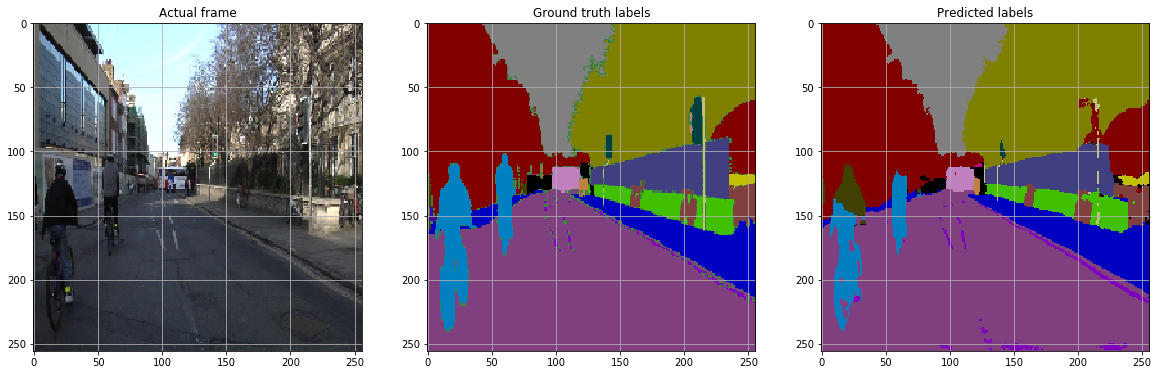

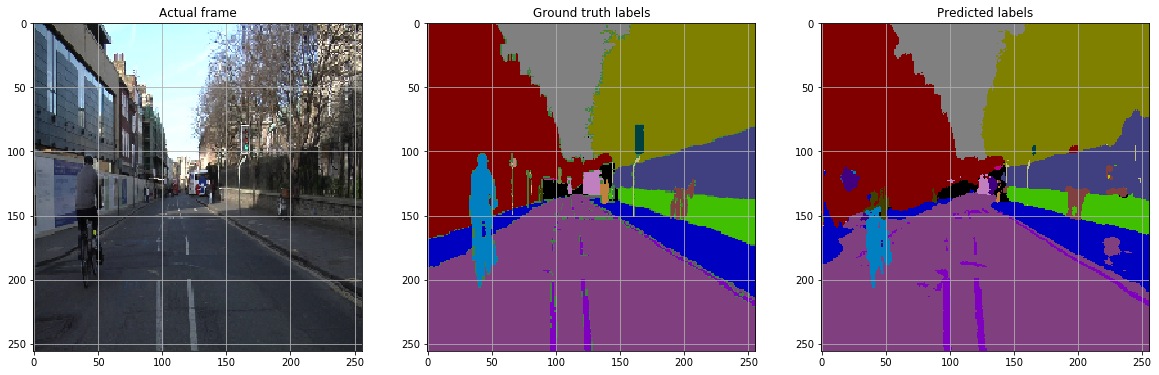

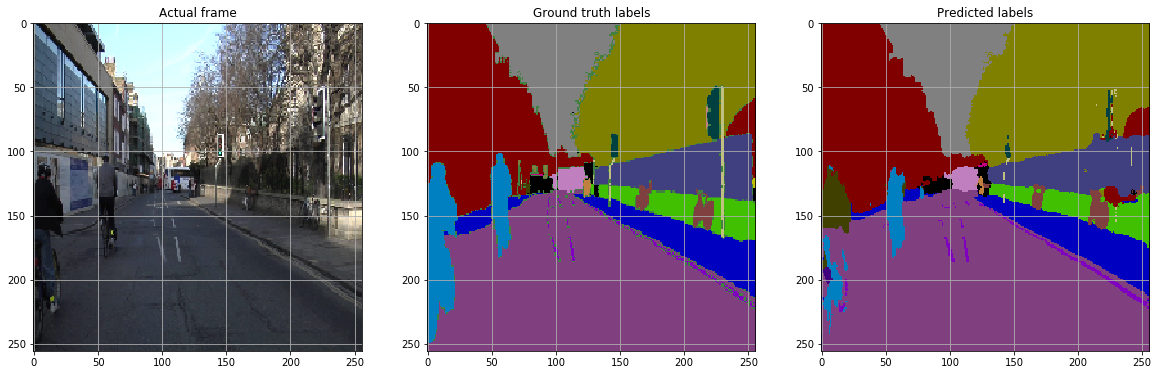

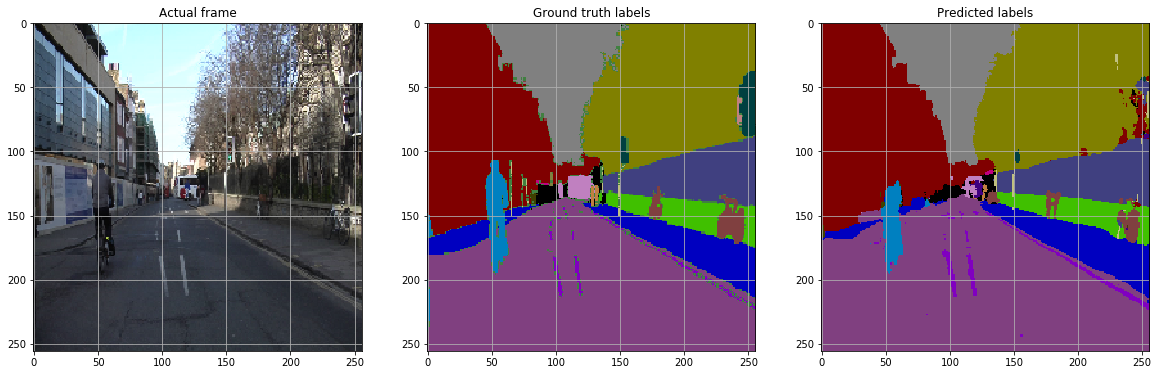

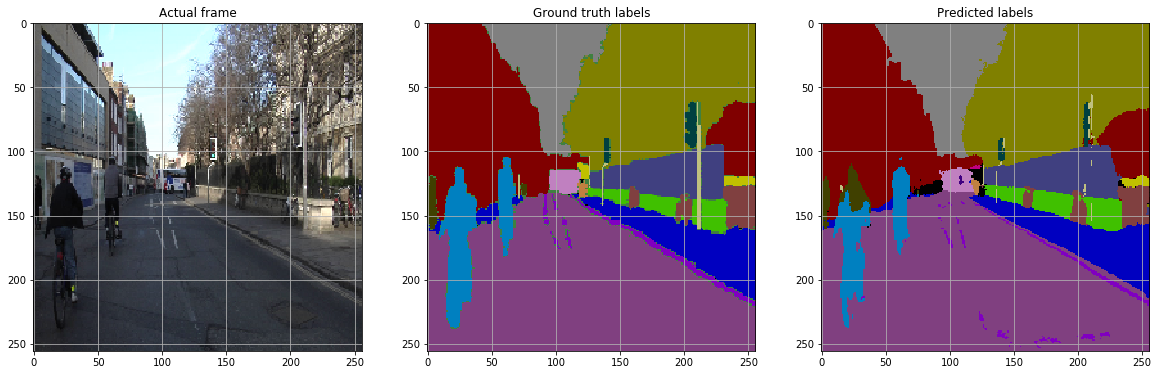

In [56]:
for i in range(0,np.shape(preds)[0]):
    fig = plt.figure(figsize=(20,8))
    
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(batch_img[i])
    ax1.title.set_text('Actual frame')
    ax1.grid(b=None)
    
    
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Ground truth labels')
    ax2.imshow(onehot_to_rgb(batch_mask[i],id2code))
    ax2.grid(b=None)
    
    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Predicted labels')
    ax3.imshow(onehot_to_rgb(preds[i],id2code))
    ax3.grid(b=None)
    
    plt.show()